In [1]:
#Importing the data
import pandas as pd
import numpy as np
import pandas as pd
from surprise import Reader, Dataset, KNNWithMeans, accuracy, PredictionImpossible
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse
from collections import defaultdict
#Importing the data
data = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/df_under.csv')
data.head()
# Create an empty DataFrame
metrics_df = pd.DataFrame(columns=['Index','Model','RMSE','MAE','MSE', 'Precision', 'Recall', 'Accuracy'])
print(metrics_df)

Empty DataFrame
Columns: [Index, Model, RMSE, MAE, MSE, Precision, Recall, Accuracy]
Index: []


In [2]:
class Knn (KNNWithMeans):
    def __init__(self, sim_options={}, bsl_options = {}):#, bsl_options={}):
        KNNWithMeans.__init__(self, sim_options=sim_options, bsl_options= bsl_options)#, bsl_options=bsl_options)
    
    def create_reader(self, data):
        reader = Reader(rating_scale=(1, 5))
        self.data = Dataset.load_from_df(data[['userId', 'wine', 'rate']], reader)
    # option 1
    ########################################
    # for cross validation we have two functions, cross_validate and fit
    def cross_validate(self, measures=['RMSE'], cv=3, verbose=False):
        results = cross_validate(self, self.data, measures=measures, cv=cv, verbose=verbose)
        for measure in measures:
            print(f'{measure}: {results["test_" + measure.lower()].mean()}')
        return results
    
    def fit(self, trainset):
        predictions = KNNWithMeans.fit(self, trainset).test(trainset.build_testset())
        self.sim = self.compute_similarities()
        self.bu, self.bi = self.compute_baselines()
        return predictions
    ########################################
    # option 2
    ########################################
    # # fit funtion that works without cross validation
    # def fit (self):
    #     self.trainset, testset = train_test_split(self.data, test_size=0.2)
    #     predictions = KNNBasic.fit(self, self.trainset).test(testset)
    #     self.sim = self.compute_similarities()
    #     self.bu, self.bi = self.compute_baselines()
    #     return predictions
    ########################################

    def estimated(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")
        
        # Compute similarities between u and v, where v describes all other
        # users that have also rated item i.
        neighbors = [(v, self.sim[u, v]) for (v, r) in self.trainset.ir[i]]
        # Sort these neighbors by similarity
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)

        print("The 5 nearest neighbors of user", str(u), "are:")
        for v, sim_uv in neighbors[:5]:
            print(f"user {v} with sim {sim_uv:1.15f}")

        # ... Aaaaand return the baseline estimate anyway ;)
        bsl = self.trainset.global_mean + self.bu[u] + self.bi[i]
        return print(f"And the baseline estimate is: {bsl}")
    
    def get_Iu(self, uid):
        """Return the number of items rated by given user
        args:
          uid: the id of the user
        returns:
          the number of items rated by the user
        """
        try:
            return len(self.trainset.ur[self.trainset.to_inner_uid(uid)])
        except ValueError:  # user was not part of the trainset
            return 0

    def get_Ui(self, iid):
        """Return the number of users that have rated given item
        args:
          iid: the raw id of the item
        returns:
          the number of users that have rated the item.
        """
        try:
            return len(self.trainset.ir[self.trainset.to_inner_iid(iid)])
        except ValueError:
            return 0

    def inspect_predictions(self, predictions):
        print(f"uid means the user id and iid means the wine id\n")
        print(f"rui means the actual rating and est means the estimated rating\n")
        print(f"err means the error between the actual and the estimated rating\n")
        print(f"Iu means the number of items rated by given user\n")
        print(f"Ui means the number of users that have rated given item\n")
        # Create a dataframe with the predictions
        df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        df_pred['Iu'] = df_pred.uid.apply(self.get_Iu)
        df_pred['Ui'] = df_pred.iid.apply(self.get_Ui)
        df_pred['err'] = abs(df_pred.est - df_pred.rui)
        return df_pred
    def get_accuracy(self, predictions, k=10, threshold=3.5):
        # Compute RMSE
        rmse = accuracy.rmse(predictions, verbose=True)
        
        # Compute MAE
        mae = accuracy.mae(predictions, verbose=True)
        
        # Compute MSE
        mse = accuracy.mse(predictions, verbose=True)
        
        # Compute precision and recall
        precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

        # Precision and recall can then be averaged over all users
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

        # Count correct predictions
        correct = 0
        for uid, iid, true_r, est, _ in predictions:
            if round(est) == round(true_r):
                correct += 1

        # Compute accuracy
        accuracy_percentage = correct / len(predictions)
        accuracy_percentage = accuracy_percentage * 100
        print(f"the acc is {accuracy_percentage:.2f}")

        # Return a dictionary with the metrics
        return {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy_percentage}
    ########################################
    # def get_accuracy(self, predictions, k=10, threshold=3.5):
    #     # Compute RMSE
    #     accuracy.rmse(predictions, verbose=True)
        
    #     # Compute precision and recall
    #     precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

    #     # Precision and recall can then be averaged over all users
    #     precision = sum(prec for prec in precisions.values()) / len(precisions)
    #     recall = sum(rec for rec in recalls.values()) / len(recalls)
    #     print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

    #     # Count correct predictions
    #     correct = 0
    #     for uid, iid, true_r, est, _ in predictions:
    #         if round(est) == round(true_r):
    #             correct += 1

    #     # Compute accuracy
    #     accuracy_percentage = correct / len(predictions)
    #     accuracy_percentage = accuracy_percentage * 100
    #     print(f"the acc is {accuracy_percentage:.2f}")
    #     return accuracy_percentage
    
    @staticmethod 
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""

        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():

            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.

            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.

            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

        return precisions, recalls
    
    # Mi function acc that works perfectly was modifyed to add precision and recall, for that reason this is commented
    # def get_accuracy(self, predictions):
    #     # # Compute RMSE
    #     # predictions = KNNBasic.test(self, testset)
    #     accuracy.rmse(predictions, verbose=True)
    #     # Count correct predictions
    #     correct = 0
    #     for uid, iid, true_r, est, _ in predictions:
    #         if round(est) == round(true_r):
    #             correct += 1

    #     # Compute accuracy
    #     accuracy_percentage = correct / len(predictions)
    #     return accuracy_percentage * 100

## KnnWithMeans and SGD

* 1 Cosine UserBased

In [3]:
knn = Knn(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.00005, 'n_epochs':20, 'reg_u': 12 , 'reg_i': 5}
    )
# create reader
knn.create_reader(data)
# cross validate
knn.cross_validate(cv=3)
# fit
trainset = knn.data.build_full_trainset()
predictions = knn.fit(trainset)
# acc
metrics = knn.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 1
metrics['Model'] = 'KnnWithMeans (cosine, sgd, user_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.0907533055370822
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.2896
MAE:  0.1064
MSE: 0.0839
Precision: 0.74
Recall: 0.73
the acc is 90.17


/tmp/ipykernel_29740/3825635489.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* 2 Cosine ItemBased

In [4]:
knn2 = Knn(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.00005, 'n_epochs':20, 'reg_u': 12 , 'reg_i': 5}
    )
# create reader
knn2.create_reader(data)
# cross validate
knn2.cross_validate(cv=3)
# fit
trainset = knn2.data.build_full_trainset()
predictions = knn2.fit(trainset)
# acc
metrics = knn2.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 2
metrics['Model'] = 'KnnWithMeans (cosine, sgd, item_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.0988433443749077
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.3181
MAE:  0.1226
MSE: 0.1012
Precision: 0.75
Recall: 0.73
the acc is 91.76


/tmp/ipykernel_29740/1116465884.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* 3 Mean Square DIfference UserBased

In [5]:
knn3 = Knn(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.00005, 'n_epochs':20, 'reg_u': 12 , 'reg_i': 5}
    )
# create reader
knn3.create_reader(data)
# cross validate
knn3.cross_validate(cv=3)
# fit
trainset = knn3.data.build_full_trainset()
predictions = knn3.fit(trainset)
# acc
metrics = knn3.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 3
metrics['Model'] = 'KnnWithMeans (mean square diff, sgd, user_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.099205735920586
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.2345
MAE:  0.0833
MSE: 0.0550
Precision: 0.75
Recall: 0.73
the acc is 93.50


/tmp/ipykernel_29740/2542978413.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* 4 Mean Square DIfference ItemBased

In [6]:
knn4 = Knn(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.00005, 'n_epochs':20, 'reg_u': 12 , 'reg_i': 5}
    )
# create reader
knn4.create_reader(data)
# cross validate
knn4.cross_validate(cv=3)
# fit
trainset = knn4.data.build_full_trainset()
predictions = knn4.fit(trainset)
# acc
metrics = knn4.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 4
metrics['Model'] = 'KnnWithMeans (mean square diff, sgd, item_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.1322867757035584
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.2881
MAE:  0.1113
MSE: 0.0830
Precision: 0.75
Recall: 0.73
the acc is 92.39


/tmp/ipykernel_29740/1273484286.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* 4 the Pearson correlation coefficient UserBased

In [7]:
knn5 = Knn(
    sim_options = {'name': 'Pearson','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.00005, 'n_epochs':20, 'reg_u': 12 , 'reg_i': 5}
    )
# create reader
knn5.create_reader(data)
# cross validate
knn5.cross_validate(cv=3)
# fit
trainset = knn5.data.build_full_trainset()
predictions = knn5.fit(trainset)
# acc
metrics = knn5.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 5
metrics['Model'] = 'KnnWithMeans (pearson corr coeff, sgd, user_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.0856714674412629
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.1963
MAE:  0.0500
MSE: 0.0386
Precision: 0.76
Recall: 0.74
the acc is 95.09


/tmp/ipykernel_29740/340158018.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* 5 the Pearson correlation coefficient ItemBased

In [8]:
knn6 = Knn(
    sim_options = {'name': 'Pearson','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.00005, 'n_epochs':20, 'reg_u': 12 , 'reg_i': 5}
    )
# create reader
knn6.create_reader(data)
# cross validate
knn6.cross_validate(cv=3)
# fit
trainset = knn6.data.build_full_trainset()
predictions = knn6.fit(trainset)
# acc
metrics = knn6.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 6
metrics['Model'] = 'KnnWithMeans (pearson corr coeff, sgd, item_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.1093091146674745
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.1952
MAE:  0.0490
MSE: 0.0381
Precision: 0.76
Recall: 0.73
the acc is 95.72


/tmp/ipykernel_29740/648236697.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* 6 the (shrunk) Pearson correlation coefficient UserBased

In [9]:
knn7 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.00005, 'n_epochs':20, 'reg_u': 12 , 'reg_i': 5}
    )
# create reader
knn7.create_reader(data)
# cross validate
knn7.cross_validate(cv=3)
# fit
trainset = knn7.data.build_full_trainset()
predictions = knn7.fit(trainset)
# acc
metrics = knn7.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 7
metrics['Model'] = 'KnnWithMeans (pearson_baseline, sgd, user_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0538104013433023
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1662
MAE:  0.0333
MSE: 0.0276
Precision: 0.76
Recall: 0.74
the acc is 97.15


/tmp/ipykernel_29740/3759819842.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* 7 the (shrunk) Pearson correlation coefficient ItemBased

In [10]:
knn8 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.00005, 'n_epochs':20, 'reg_u': 12 , 'reg_i': 5}
    )
# create reader
knn8.create_reader(data)
# cross validate
knn8.cross_validate(cv=3)
# fit
trainset = knn8.data.build_full_trainset()
predictions = knn8.fit(trainset)
# acc
metrics = knn8.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 8
metrics['Model'] = 'KnnWithMeans (pearson_baseline, sgd, item_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.1007992683371701
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1667
MAE:  0.0353
MSE: 0.0278
Precision: 0.76
Recall: 0.74
the acc is 97.15


/tmp/ipykernel_29740/1293986375.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


## KnnWithMeans and ALS


* 1 Cosine UserBased

In [11]:
knn9 = Knn(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':20 }
    )
#create the reader
knn9.create_reader(data)
#cross validate
knn9.cross_validate(cv=3)
#build the trainset
trainset = knn9.data.build_full_trainset()
predictions = knn9.fit(trainset)
#get the accuracy
# only print the accuracy
metrics = knn9.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 9
metrics['Model'] = 'KnnWithMeans (cosine, als, user_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.0662302603406815
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.2896
MAE:  0.1064
MSE: 0.0839
Precision: 0.74
Recall: 0.73
the acc is 90.17


/tmp/ipykernel_29740/2826912693.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* 2 Cosine ItemBased

In [12]:
knn10 = Knn(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':20, 'reg_u': 12 , 'reg_i': 5}
    )
# create reader
knn10.create_reader(data)
# cross validate
knn10.cross_validate(cv=3)
# fit
trainset = knn10.data.build_full_trainset()
predictions = knn10.fit(trainset)
# acc
metrics = knn10.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 10
metrics['Model'] = 'KnnWithMeans (cosine, als, item_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.0803477752652
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.3181
MAE:  0.1226
MSE: 0.1012
Precision: 0.75
Recall: 0.73
the acc is 91.76


/tmp/ipykernel_29740/3261879031.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* 3 Mean Square Difference UserBased

In [13]:
knn11 = Knn(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':20 }
    )
#create the reader
knn11.create_reader(data)
#cross validate
knn11.cross_validate(cv=3)
#build the trainset
trainset = knn11.data.build_full_trainset()
predictions = knn11.fit(trainset)
#get the accuracy
# only print the accuracy
metrics = knn11.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 11
metrics['Model'] = 'KnnWithMeans (mean square diff, als, user_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.076990464502327
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.2345
MAE:  0.0833
MSE: 0.0550
Precision: 0.75
Recall: 0.73
the acc is 93.50


/tmp/ipykernel_29740/3077974634.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* 4 Mean Square Difference ItemBased

In [14]:
knn12 = Knn(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':20 }
    )
#create the reader
knn12.create_reader(data)
#cross validate
knn12.cross_validate(cv=3)
#build the trainset
trainset = knn12.data.build_full_trainset()
predictions = knn12.fit(trainset)
#get the accuracy
# only print the accuracy
metrics = knn12.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 12
metrics['Model'] = 'KnnWithMeans (mean square diff, als, item_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.1091336354325996
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.2881
MAE:  0.1113
MSE: 0.0830
Precision: 0.75
Recall: 0.73
the acc is 92.39


/tmp/ipykernel_29740/1215148594.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* 5 Pearson correlation coefficient UserBased

In [15]:
knn13 = Knn(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':20 }
    )
#create the reader
knn13.create_reader(data)
#cross validate
knn13.cross_validate(cv=3)
#build the trainset
trainset = knn13.data.build_full_trainset()
predictions = knn13.fit(trainset)
#get the accuracy
# only print the accuracy
metrics = knn13.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 13
metrics['Model'] = 'KnnWithMeans (pearson corr coeff, als, user_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.0921314912889395
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.1963
MAE:  0.0500
MSE: 0.0386
Precision: 0.76
Recall: 0.74
the acc is 95.09


/tmp/ipykernel_29740/1754626007.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* 6 Pearson correlation coefficient ItemBased

In [16]:
knn14 = Knn(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':20 }
    )
#create the reader
knn14.create_reader(data)
#cross validate
knn14.cross_validate(cv=3)
#build the trainset
trainset = knn14.data.build_full_trainset()
predictions = knn14.fit(trainset)
#get the accuracy
# only print the accuracy
metrics = knn14.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 14
metrics['Model'] = 'KnnWithMeans (pearson corr coeff, als, item_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.0819418133080543
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.1952
MAE:  0.0490
MSE: 0.0381
Precision: 0.76
Recall: 0.73
the acc is 95.72


/tmp/ipykernel_29740/3052309714.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* 7 the (shrunk) Pearson correlation coefficient UsedBased

In [17]:
knn15 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':20 }
    )
#create the reader
knn15.create_reader(data)
#cross validate
knn15.cross_validate(cv=3)
#build the trainset
trainset = knn15.data.build_full_trainset()
predictions = knn15.fit(trainset)
#get the accuracy
# only print the accuracy
metrics = knn15.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 15
metrics['Model'] = 'KnnWithMeans (pearson_baseline, als, user_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0776398786093406
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1662
MAE:  0.0330
MSE: 0.0276
Precision: 0.76
Recall: 0.74
the acc is 97.15


/tmp/ipykernel_29740/452385450.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* 8 the (shrunk) Pearson correlation coefficient ItemBased

In [18]:
knn16 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':20 }
    )
#create the reader
knn16.create_reader(data)
#cross validate
knn16.cross_validate(cv=3)
#build the trainset
trainset = knn16.data.build_full_trainset()
predictions = knn16.fit(trainset)
#get the accuracy
##################
metrics = knn16.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 16
metrics['Model'] = 'KnnWithMeans (pearson_baseline, als, item_based)'

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.1154732699711971
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1665
MAE:  0.0345
MSE: 0.0277
Precision: 0.76
Recall: 0.74
the acc is 97.15


/tmp/ipykernel_29740/1903075587.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [19]:
metrics_df.sort_values(by='RMSE', ascending=True, inplace=True)
metrics_df


,Index,Model,RMSE,MAE,MSE,Precision,Recall,Accuracy
14,15,"KnnWithMeans (pearson_baseline, als, user_based)",0.166186,0.032976,0.027618,0.760369,0.737914,97.147385
6,7,"KnnWithMeans (pearson_baseline, sgd, user_based)",0.166226,0.033291,0.027631,0.760369,0.737914,97.147385
15,16,"KnnWithMeans (pearson_baseline, als, item_based)",0.166491,0.034471,0.027719,0.760369,0.737914,97.147385
7,8,"KnnWithMeans (pearson_baseline, sgd, item_based)",0.166729,0.035318,0.027799,0.760369,0.737914,97.147385
5,6,"KnnWithMeans (pearson corr coeff, sgd, item_ba...",0.195182,0.049009,0.038096,0.758218,0.734688,95.721078
13,14,"KnnWithMeans (pearson corr coeff, als, item_ba...",0.195182,0.049009,0.038096,0.758218,0.734688,95.721078
4,5,"KnnWithMeans (pearson corr coeff, sgd, user_ba...",0.196348,0.050038,0.038552,0.758065,0.736301,95.087163
12,13,"KnnWithMeans (pearson corr coeff, als, user_ba...",0.196348,0.050038,0.038552,0.758065,0.736301,95.087163
2,3,"KnnWithMeans (mean square diff, sgd, user_based)",0.234543,0.083294,0.055010,0.752258,0.734688,93.502377
10,11,"KnnWithMeans (mean square diff, als, user_based)",0.234543,0.083294,0.055010,0.752258,0.734688,93.502377


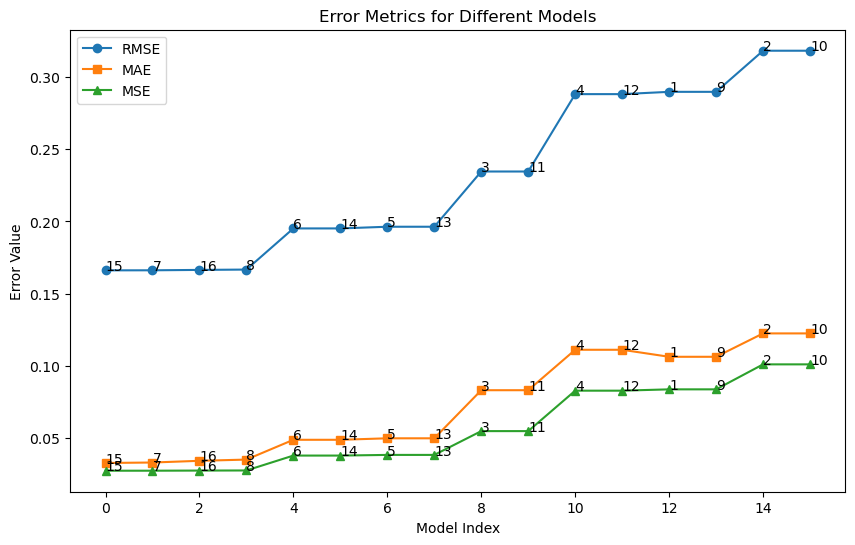

In [20]:
import matplotlib.pyplot as plt

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

# Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MAE'], marker='s', linestyle='-', label='MAE')

# Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MSE'], marker='^', linestyle='-', label='MSE')

# Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MAE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MSE'].iloc[i]))

# Set title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

# Add a legend
plt.legend()

# Show the plot
plt.show()

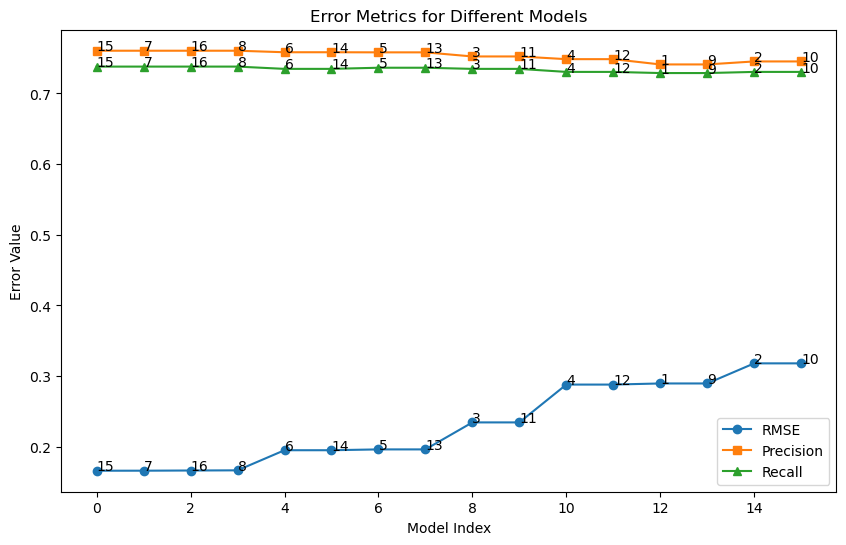

In [21]:
import matplotlib.pyplot as plt

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

# Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Precision'], marker='s', linestyle='-', label='Precision')

# Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Recall'], marker='^', linestyle='-', label='Recall')

# Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Precision'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Recall'].iloc[i]))

# Set title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

# Add a legend
plt.legend()

# Show the plot
plt.show()

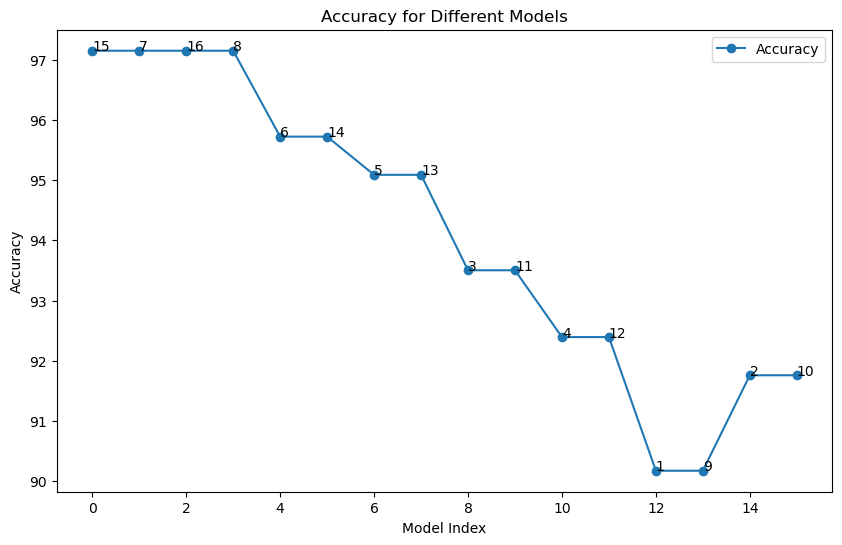

In [22]:
import matplotlib.pyplot as plt

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot Accuracy with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Accuracy'], marker='o', linestyle='-', label='Accuracy')

# Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Accuracy'].iloc[i]))

# Set title and labels
plt.title('Accuracy for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Accuracy')

# Add a legend
plt.legend()

# Show the plot
plt.show()
